# Gaussian Hidden Markov Models

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from models.HMM import HMM
from models.posteriors import wishart,norm, dirichlet, simul_s, _Phi,order
from models.simulation import simul_gauss

# We will fit a two component gaussian HMM

A 2 components gaussian HMM is made of :
* A posterior `normal-inverse_wishart` distribution over $\theta = (\mu,\Sigma) \in IR^{2xd}xIR^{2xdxd}$; where $d$ = dim of the gaussian vectors
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by defining the posterior of $\theta = \left(\mu,\Sigma\right)$

In [4]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \0mega^{-1} is simulated instead \Omega

#Let set the default parameters

d = 3 # dim of our gaussian vectors

nu = np.array([20, 20]) # Degree of freedoms of the prior of \Omega
omega_inv = 30*np.array([np.eye(d), np.eye(d)]) # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d), np.zeros(d)]) # Mean of the prior over  \mu
sigma = 30*np.array([np.eye(d), np.eye(d) ]) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)
tDictDist["mu"]._set( mu = mu, sigma_inv = sigma)
tDictDist["omega_inv"]._set(nu = nu, omega_inv = omega_inv)

Now, the **S** distribtuion ...

In [5]:
sDist = simul_s(func = _Phi) # S distribution

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[0.5, 0.5], [0.5,0.5]]))

In [7]:
pDist.default

{'a': 1}

# The gaussian mixture on an artificial data

## Simulate the data
Let's simulate an artificial gaussian mixture

In [50]:
P0 = np.array([[0.2, 0.8], [0.6, 0.4]]) # the 'true' transition matrix
mu0 = np.array([-5*np.ones(d), 5*np.ones(d)])# The 'true' means
sigma0 = 5*np.array([np.eye(d), np.eye(d)]) # The true cov matrixes

In [51]:
y, S0 = simul_gauss(P0,mu0, sigma0, 500) # Simulate 500 sample of poisson mixtures
y[:5] , S0[:5] 

(array([[-2.72457876, -2.36327565, -3.92671709],
        [ 1.33987626,  7.36704496,  2.93636939],
        [-4.26727575, -2.20902865, -4.58787464],
        [ 7.38968995,  3.62459432,  5.89770299],
        [ 2.32130661,  4.78731439,  3.96139408]]), array([0, 1, 0, 1, 1]))

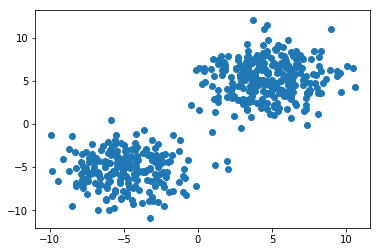

In [52]:
plt.scatter(y[:,0], y[:, 1])  # Our clusters

Now, we're gonna define the gHMM

## Running the HMM

In [11]:
Y = y # Obs
S = np.random.choice(2, len(Y)) # Initial states
P = np.array([[0.5,0.5],[0.5,0.5]]) # Initial transition matrix
mu =  np.array([ np.zeros(d), np.zeros(d) ]) # Inital 'mean'
omega_inv =  np.array([np.eye(d),np.eye(d)])/30 # Initial cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Inital parameters sample

In [12]:
ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [53]:
ghmm.run(3000) # Start the gibbs sampler n-times

## Checking for auto-correlation in the chain

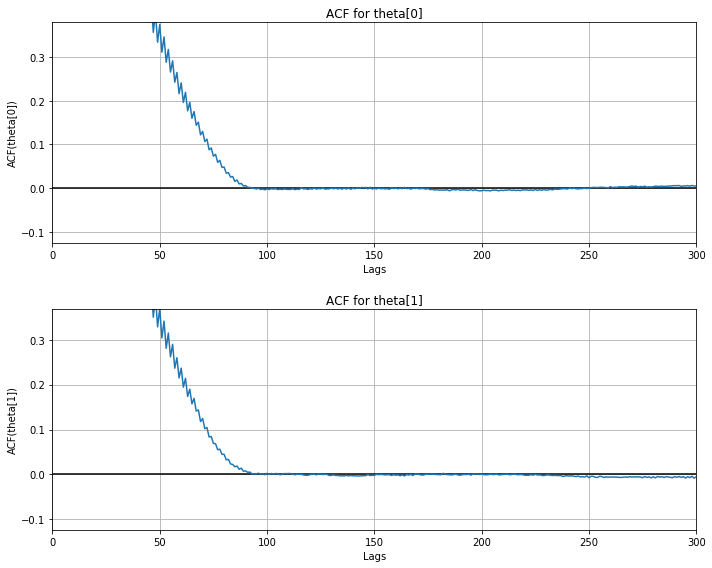

In [54]:
from models.utils import plot_ACF

mus = np.array([x["mu"].flatten() for x in ghmm.H["Theta"]]) # Only plotting for mu

plot_ACF(mus[:, :2], nlags = 300)

The auto-correlation decrease toward zero. The chain seems generated correctly.

# Can we recover the true clusters ? Let's see !

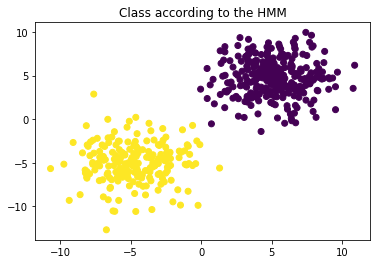

In [55]:
plt.figure()
plt.title("Class according to the HMM")
plt.scatter(Y[:,0], Y[:,1], c= ghmm.S)

In [23]:
(ghmm.sDist.rvs() == S0).mean() # Precision or Error rate

0.0

In [24]:
# Compute the mode for each obs
Sgmm = np.array(ghmm.H["S"][-20::])
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = 2 )
Sgmm = Sgmm.argmax(0)
Sgmm[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [26]:
(Sgmm == S0 ).mean() # Precision or Error rate

0.0

# Recover the parameters

In [27]:
ghmm.Theta

{'mu': array([[ 5.00647863,  4.70294189,  4.60239277],
        [-4.56664522, -5.11367472, -5.08040957]]),
 'omega_inv': array([[[ 0.26704591, -0.00642738, -0.00380842],
         [-0.00642738,  0.23671984,  0.03618999],
         [-0.00380842,  0.03618999,  0.21654084]],
 
        [[ 0.25665857, -0.03190126, -0.01202227],
         [-0.03190126,  0.17836967,  0.01719706],
         [-0.01202227,  0.01719706,  0.17820867]]])}

In [29]:
[history["mu"] for history in ghmm.H["Theta"][-5::]] # Last 5 mu samples

[array([[ 4.99491646,  4.64490186,  4.90209806],
        [-4.84536653, -4.7943542 , -4.64776152]]),
 array([[ 4.9899894 ,  4.5949604 ,  4.99599868],
        [-4.39977476, -4.97513749, -5.30339539]]),
 array([[ 4.82821856,  4.70881595,  4.81506111],
        [-4.85576362, -4.98229062, -4.98243378]]),
 array([[ 4.98999491,  4.79458682,  4.78525753],
        [-4.79138448, -4.74546332, -5.16728657]]),
 array([[ 5.07118754,  4.62910339,  4.79224188],
        [-4.5857381 , -4.95351824, -4.91403399]])]

In [30]:
ghmm.H["P"][-10::] # Last 10 samples of P

[array([[0.46688284, 0.53311716],
        [0.77961952, 0.22038048]]), array([[0.43073481, 0.56926519],
        [0.7407863 , 0.2592137 ]]), array([[0.43213632, 0.56786368],
        [0.83789696, 0.16210304]]), array([[0.41092574, 0.58907426],
        [0.83143486, 0.16856514]]), array([[0.41557013, 0.58442987],
        [0.81138747, 0.18861253]]), array([[0.45315311, 0.54684689],
        [0.78024027, 0.21975973]]), array([[0.44254391, 0.55745609],
        [0.80238663, 0.19761337]]), array([[0.41043673, 0.58956327],
        [0.81517691, 0.18482309]]), array([[0.43270453, 0.56729547],
        [0.79278574, 0.20721426]]), array([[0.46507781, 0.53492219],
        [0.83947256, 0.16052744]])]

#  Comparison with Kmeans

In [31]:
from sklearn.cluster import KMeans

In [59]:
km = KMeans(n_clusters= 2)

In [60]:
km.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

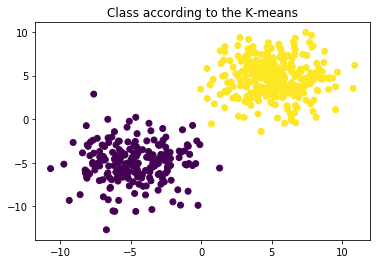

In [61]:
plt.figure()
plt.title("Class according to the K-means")
plt.scatter(Y[:,0], Y[:,1], c= km.labels_)

K-means gives the same results